In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
from point import Point

def get_comm_boundaries():
    boundaries = []
    for i in range(1, 7):
        with open(f'commercial_boundary{i}.pickle', 'rb') as handle:
            boundaries.append(pickle.load(handle))
    return boundaries

def get_metro_boundary():
    with open('metro_boundary.pickle', 'rb') as handle:
        metro = pickle.load(handle)
    return metro

def point_in_metro(point):
    return get_metro_boundary().point_inside(point) >= 1

def point_in_commercial(point):
    for boundary in get_comm_boundaries():
        if boundary.point_inside(point):
            return True
    return False

def get_trip_class(row):
    # point inside: 0, 1, 2
        # 0: outside polygon
        # 1: inside polygon
        # 2: on the polygon

    start = Point(row['START LAT'], row['START LONG'])
    end = Point(row['END LAT'], row['END LONG'])

    start_in_metro = point_in_metro(start)
    end_in_metro = point_in_metro(end)
    start_in_comm = point_in_commercial(start)
    end_in_comm = point_in_commercial(end)
    start_in_res = not start_in_metro and not start_in_comm
    end_in_res = not end_in_metro and not end_in_comm

    # Trip classes:
        # B = start inside boundary, end outside boundary
        # C = start inside boundary, end outside boundary

    if start_in_metro and not end_in_metro:
        return 'Metro', 'B'
    elif not start_in_metro and end_in_metro:
        return 'Metro', 'C'
    elif start_in_comm and not end_in_comm:
        return 'Commercial', 'B'
    elif not start_in_comm and end_in_comm:
        return 'Commercial', 'C'
    elif start_in_res and not end_in_res:
        return 'Residential', 'B'
    elif not start_in_res and end_in_res:
        return 'Residential', 'C'
    else:
        return np.NAN, np.NAN

df = pd.read_csv('scooters.csv')
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'PATH', 'TIMESTAMPS'], axis=1)

df['TRIP_TYPE'] = df.apply (lambda row: get_trip_class(row)[0], axis=1)
df['TRIP_CLASS'] = df.apply (lambda row: get_trip_class(row)[1], axis=1)
df1 = df[df['TRIP_CLASS'] == 'B']
df2 = df[df['TRIP_CLASS'] == 'C']

# df1.to_csv('MetroRides.csv')
# df2.to_csv('CommercialRides.csv')
# df3.to_csv('ResidentialRides.csv')

In [4]:
df.groupby('TRIP_TYPE').count()

,CREATED,START,END,DISTANCE,RIDE_ID,CUSTOMER_ID,MINUTES,VEHICLE_TYPE,START LONG,START LAT,END LONG,END LAT,TRIP_CLASS
TRIP_TYPE,,,,,,,,,,,,,
Commercial,11148,11148,11148,11148,11148,11148,11148,11148,11148,11148,11148,11148,11148
Metro,1969,1969,1969,1969,1969,1969,1969,1969,1969,1969,1969,1969,1969


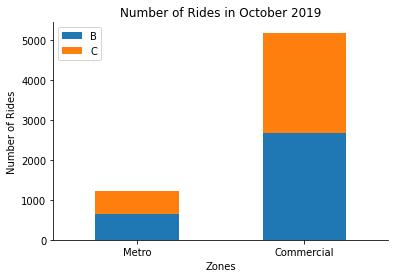

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_zone_plot(df, year):
    dfyear = df[df['CREATED'].str.startswith(f'{year}')]
    b = dfyear[dfyear['TRIP_CLASS'] == 'B'].groupby('TRIP_TYPE').count()['TRIP_CLASS']
    c = dfyear[dfyear['TRIP_CLASS'] == 'C'].groupby('TRIP_TYPE').count()['TRIP_CLASS']
    data_year = pd.DataFrame({'B': b, 'C': c}, index=['Metro', 'Commercial'])

    ax = data_year.plot.bar(stacked=True, rot=0)
    ax.legend()
    plt.xlabel('Zones')
    plt.ylabel('Number of Rides')
    plt.title(f'Number of Rides in October {year}')

    sns.despine()
    plt.show()

get_zone_plot(df, 2019)